### Group: Emma and Frankie
KNN Regression

In [1]:
# Import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cartopy as cp
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Import data and take a very quick look at it
jmadata = pd.read_csv("./Data/jma_nitrate.csv")
# jmadata = pd.read_csv("../data/jma_nitrate.csv") # please do not change. comment out & use path above. 
jmadata.columns

Index(['Unnamed: 0', 'theta', 'sal', 'depth', 'nitrate', 'lon', 'lat', 'date',
       'year', 'month', 'day', 'profile', 'cruise', 'vessel', 'density'],
      dtype='object')

In [3]:
# Import Argo data without nitrate

# emma's path
bgcdata = pd.read_csv('./Data/kuro_BGCargo_noNO3.csv')

# franky's path
# do not change code a below just comment out and pull back in your code.
# infile = "../data/kuro_BGCargo_noNO3_2.csv"  
# bgcdata = pd.read_csv(infile, delimiter= ',')


bgcdata['year'] = pd.DatetimeIndex(bgcdata['Date/GMT']).year
bgcdata['month'] = pd.DatetimeIndex(bgcdata['Date/GMT']).month
bgcdata.columns





Index(['Date/GMT', 'Days since 1/1/1900', 'DEPTH[M]', 'PRESSURE[DBAR]', 'NA',
       'SALINITY[PSS]', 'TEMPERATURE[C]', 'SIGMATHETA[KG/M3]',
       'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT', 'year', 'month'],
      dtype='object')

In [56]:
# Import Argo nitrate data
# emma's path
bgcno3data = pd.read_csv('./data/kuro_BGCargo_NO3.csv', delimiter=',')
# franky's path
# bgcno3data = pd.read_csv('../data/kuro_BGCargo_NO3_2.csv', delimiter=',')


bgcno3data['year'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).year
bgcno3data['month'] = pd.DatetimeIndex(bgcno3data['Date/GMT']).month
bgcno3data.columns




Index(['Date/GMT', 'Days since 1/1/1900', 'NITRATE[uMOL/KG]', 'DEPTH[M]',
       'PRESSURE[DBAR]', 'NA', 'SALINITY[PSS]', 'TEMPERATURE[C]',
       'SIGMATHETA[KG/M3]', 'OXYGEN[uMOL/KG]', 'OXYGENSAT', 'LON', 'LAT',
       'year', 'month'],
      dtype='object')

## Part 1 (20 points): EDA ## 

Before you apply your model, assess the level of overlap between the range of environmental conditions represented in the JMA and BGC Argo data sets.

Compare the geographical extent, depth range, water masses, seasonal coverage and any other factors that you think could be pertinent between the two data sets.
Describe similarities and highlight differences.

In [57]:
# Since we have a NaN value for nitrate (-999) we need to get rid of that (also negavtive values in bgc)
jmadata = jmadata[jmadata['nitrate']>0]
bgcno3data = bgcno3data[bgcno3data['NITRATE[uMOL/KG]']>0]

In [6]:
jmadata.describe()

,Unnamed: 0,theta,sal,depth,nitrate,lon,lat,year,month,day,profile,density
count,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000,15574.000000
mean,8175.135932,7.042844,34.433404,1418.388211,26.855277,151.599624,32.696928,2012.313664,6.851034,13.509375,268.636766,26.574613
std,4675.484666,7.113994,0.354281,1528.846644,15.480812,9.692016,8.979100,1.684952,2.660677,8.723439,148.651926,1.221275
min,0.000000,0.034400,32.349200,0.000000,0.010000,133.990833,0.332167,2010.000000,2.000000,1.000000,1.000000,20.951302
25%,4105.250000,1.589650,34.240600,203.000000,11.250000,145.727833,30.003333,2011.000000,5.000000,6.000000,139.000000,25.882225
50%,8228.500000,3.418650,34.550800,803.000000,35.350000,148.149667,34.239500,2012.000000,7.000000,12.000000,275.000000,27.094050
75%,12223.750000,12.294850,34.681800,2002.000000,39.797500,164.231000,39.660833,2013.000000,9.000000,20.000000,394.000000,27.527512
max,16220.000000,29.923300,35.548100,6161.000000,45.330000,170.035167,49.991500,2016.000000,12.000000,31.000000,529.000000,27.681606


For JMA data: Looking at the basic minimums and maximums for each variable, it does not look like there are any other extreme outliers (or NA values in the form of way off numbers). It looks like the samples range from around 133º to 170º longitude, and 0º to 50º latitude, but we will look more into this later. Collections occured between 2010 and 2016, with no sampling in January for any years (no month = 1). 

In [9]:
bgcno3data.describe()

,Days since 1/1/1900,NITRATE[uMOL/KG],DEPTH[M],PRESSURE[DBAR],NA,SALINITY[PSS],TEMPERATURE[C],SIGMATHETA[KG/M3],OXYGEN[uMOL/KG],OXYGENSAT,LON,LAT,year,month
count,14118.000000,14118.000000,14118.000000,14118.000000,14118.000000,14118.000000,14118.000000,14118.000000,1.411800e+04,1.411800e+04,14118.000000,14118.00000,14118.000000,14118.000000
mean,42020.134744,13.167418,-308.132532,-310.725492,6.641167,34.444247,13.177575,25.800810,inf,inf,166.996243,33.43037,2014.531095,6.641167
std,411.744603,13.164640,257.806675,260.216590,3.261655,0.266298,5.165774,0.827549,inf,inf,6.850736,1.98193,1.112432,3.261655
min,41335.568000,0.010000,-990.493000,-999.800000,1.000000,33.675300,3.018000,21.966000,2.280000e+01,7.100000e+00,148.325000,30.09200,2013.000000,1.000000
25%,41658.354000,3.660000,-378.556500,-381.590000,4.000000,34.234225,9.525750,25.350000,1.864000e+02,7.000000e+01,162.973000,31.81300,2014.000000,4.000000
50%,42018.476000,7.990000,-239.649500,-241.500000,7.000000,34.484300,14.511050,25.706000,2.095000e+02,8.410000e+01,169.174000,32.74100,2015.000000,7.000000
75%,42382.406000,17.690000,-110.028500,-110.860000,9.000000,34.669550,16.709075,26.357000,2.247000e+02,9.300000e+01,171.626000,35.10400,2016.000000,9.000000
max,42736.536000,50.460000,-5.450000,-5.490000,12.000000,35.350200,27.426200,27.410000,1.790000e+308,1.790000e+308,176.199000,37.75900,2017.000000,12.000000


For BGC Argo data: Looking at the basic minimums and maximums, there no longer seem to be any extreme outliers (or NA values in the form of way off numbers). The Oxygen data has infinite mean and std, but we aren't looking at that data so we don't need to get into that. The samples range from about 148º to 178º longitude and 30º to 40º latitude, which we will look at more in depth shortly. Collections occur between 2013 and 2017, with collections happening in the full range of months (starts at January). Depth is on a different scale than JMA - it is negative, which we will fix later.

Text(0, 0.5, 'Number of Observations per bin')

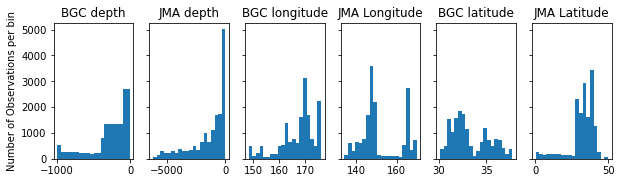

In [59]:
n_bins = 20
fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize = (10,2.5),sharey=True)

ax1.hist(bgcdata['DEPTH[M]'], bins=n_bins)
ax2.hist(-jmadata['depth'], bins=n_bins)
ax3.hist(bgcdata['LON'], bins=n_bins)
ax4.hist(jmadata['lon'], bins=n_bins)
ax5.hist(bgcdata['LAT'], bins=n_bins)
ax6.hist(jmadata['lat'], bins=n_bins)

ax1.set_title("BGC depth")
ax2.set_title("JMA depth")
ax3.set_title("BGC longitude")
ax4.set_title("JMA Longitude")
ax5.set_title("BGC latitude")
ax6.set_title("JMA Latitude")

ax1.set_ylabel('Number of Observations per bin')

# need to create space in these plots or dial in the text size.... 

Text(0, 0.5, 'Number of Observations per year')

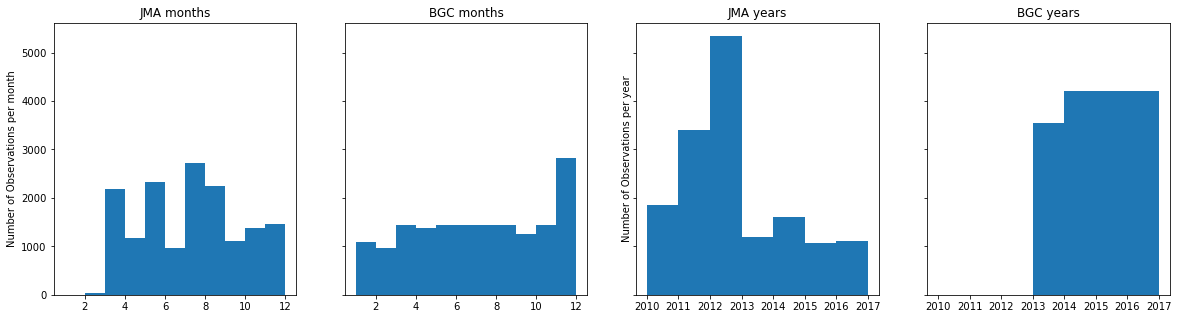

In [60]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize = (20,5),sharey=True)

month_bins = range(1,13,1)
ax1.hist(jmadata['month'], month_bins)
ax2.hist(bgcdata['month'], month_bins)

year_bins = range(2010, 2018, 1)
ax3.hist(jmadata['year'], year_bins)
ax4.hist(bgcdata['year'],  year_bins)

ax1.set_title("JMA months")
ax2.set_title("BGC months")
ax3.set_title("JMA years")
ax4.set_title("BGC years")

ax1.set_ylabel('Number of Observations per month')
ax3.set_ylabel('Number of Observations per year')



/Users/Emma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/Emma/opt/anaconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:331: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


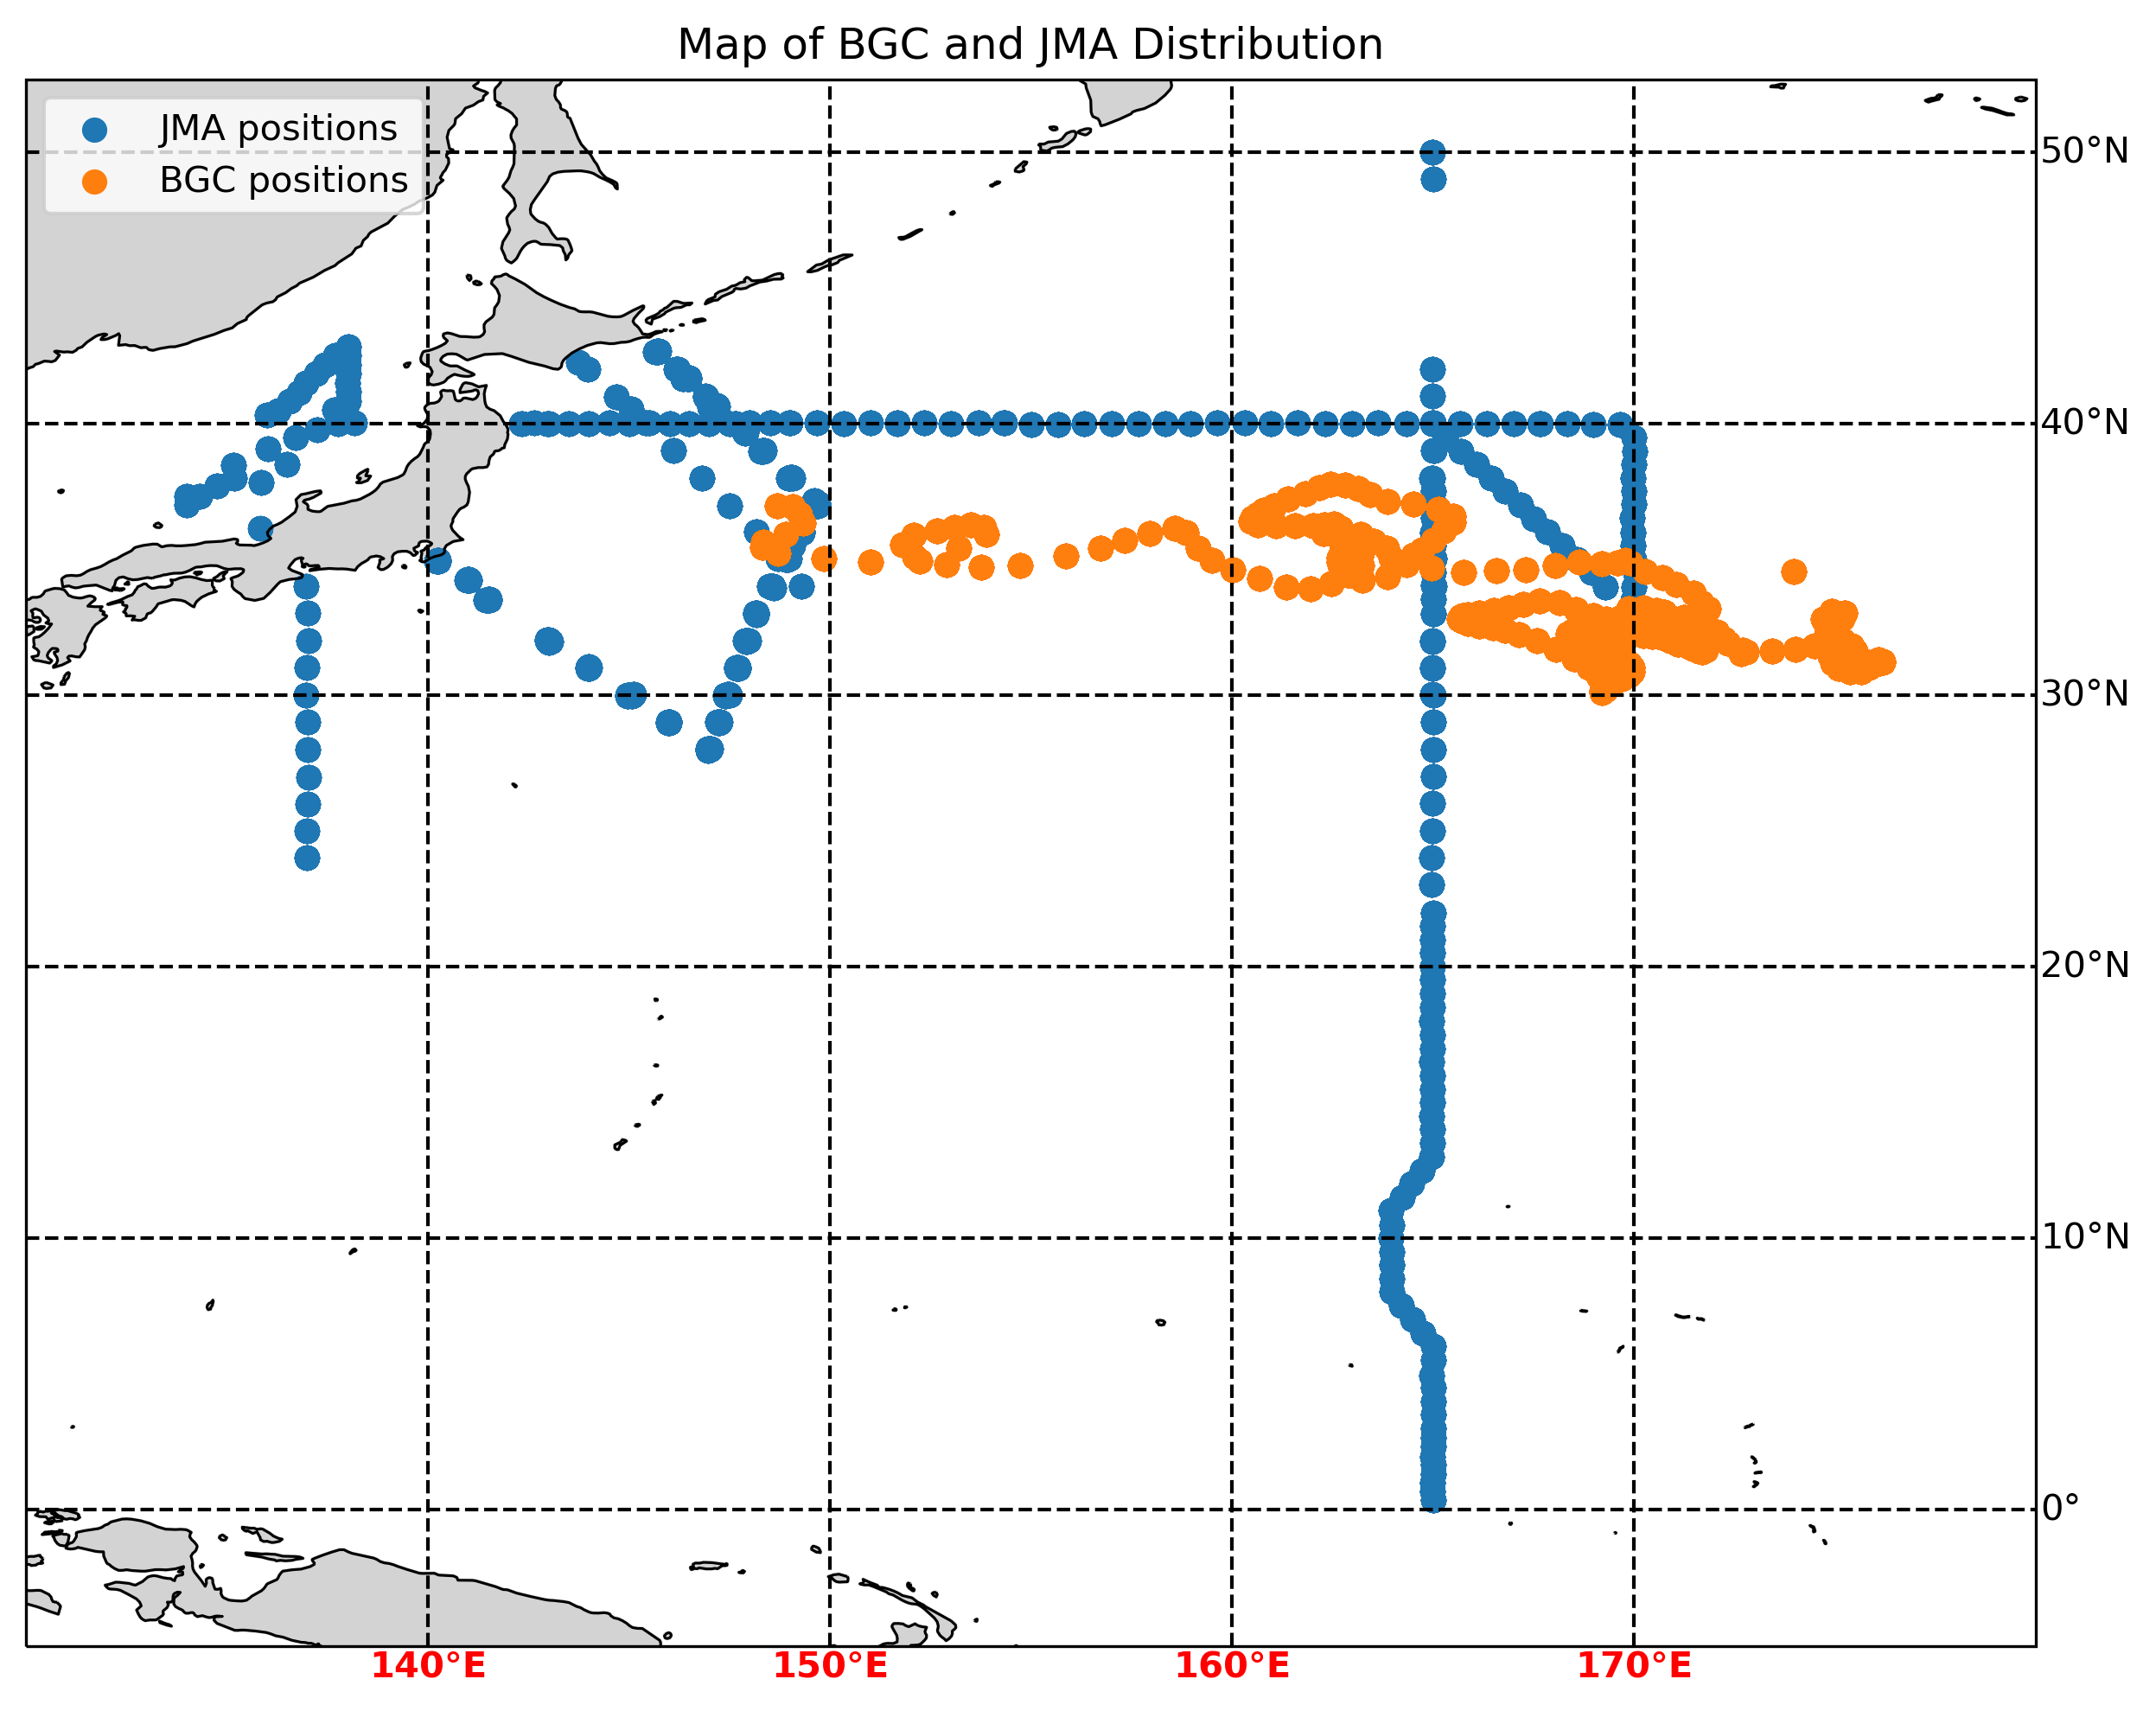

In [61]:
# Create a regional map with parallels and meridians

fig = plt.figure(figsize = (10,8), dpi = 300)
ax = fig.add_subplot(1,1,1, projection = ccrs.PlateCarree(), aspect = "auto", adjustable = "box")

# ax.set_extent(east, west, south, north)
ax.set_extent([130.0, 180.0, -5, 50.0])

# Being picky with our coastlines
ax.coastlines(linewidth=0.75, color='black')

# Map title
ax.set_title('Map of BGC and JMA Distribution')#, color = 'red', weight = 'bold')
# how to add lines of latitude and longitude
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

line1=ax.scatter(jmadata['lon'],jmadata['lat'], c= '#1f77b4')
line2=ax.scatter(bgcdata['LON'],bgcdata['LAT'], c= '#ff7f0e')
ax.legend([line1, line2], ['JMA positions', 'BGC positions'],loc=2, prop={'size': 10})

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k',linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

ax.add_feature(cp.feature.LAND, facecolor = 'lightgrey')


When looking at the distribution of sample collection, JMA obviously spans a wider area than BGC, but they are in similar regions, and there is some small amount of direct overlap. JMA does get much closer to coast lines, so nitrate could be influenced by coastal processes in some of that data. 

Text(0.5, 1.0, 'BGC T-S Diagram')

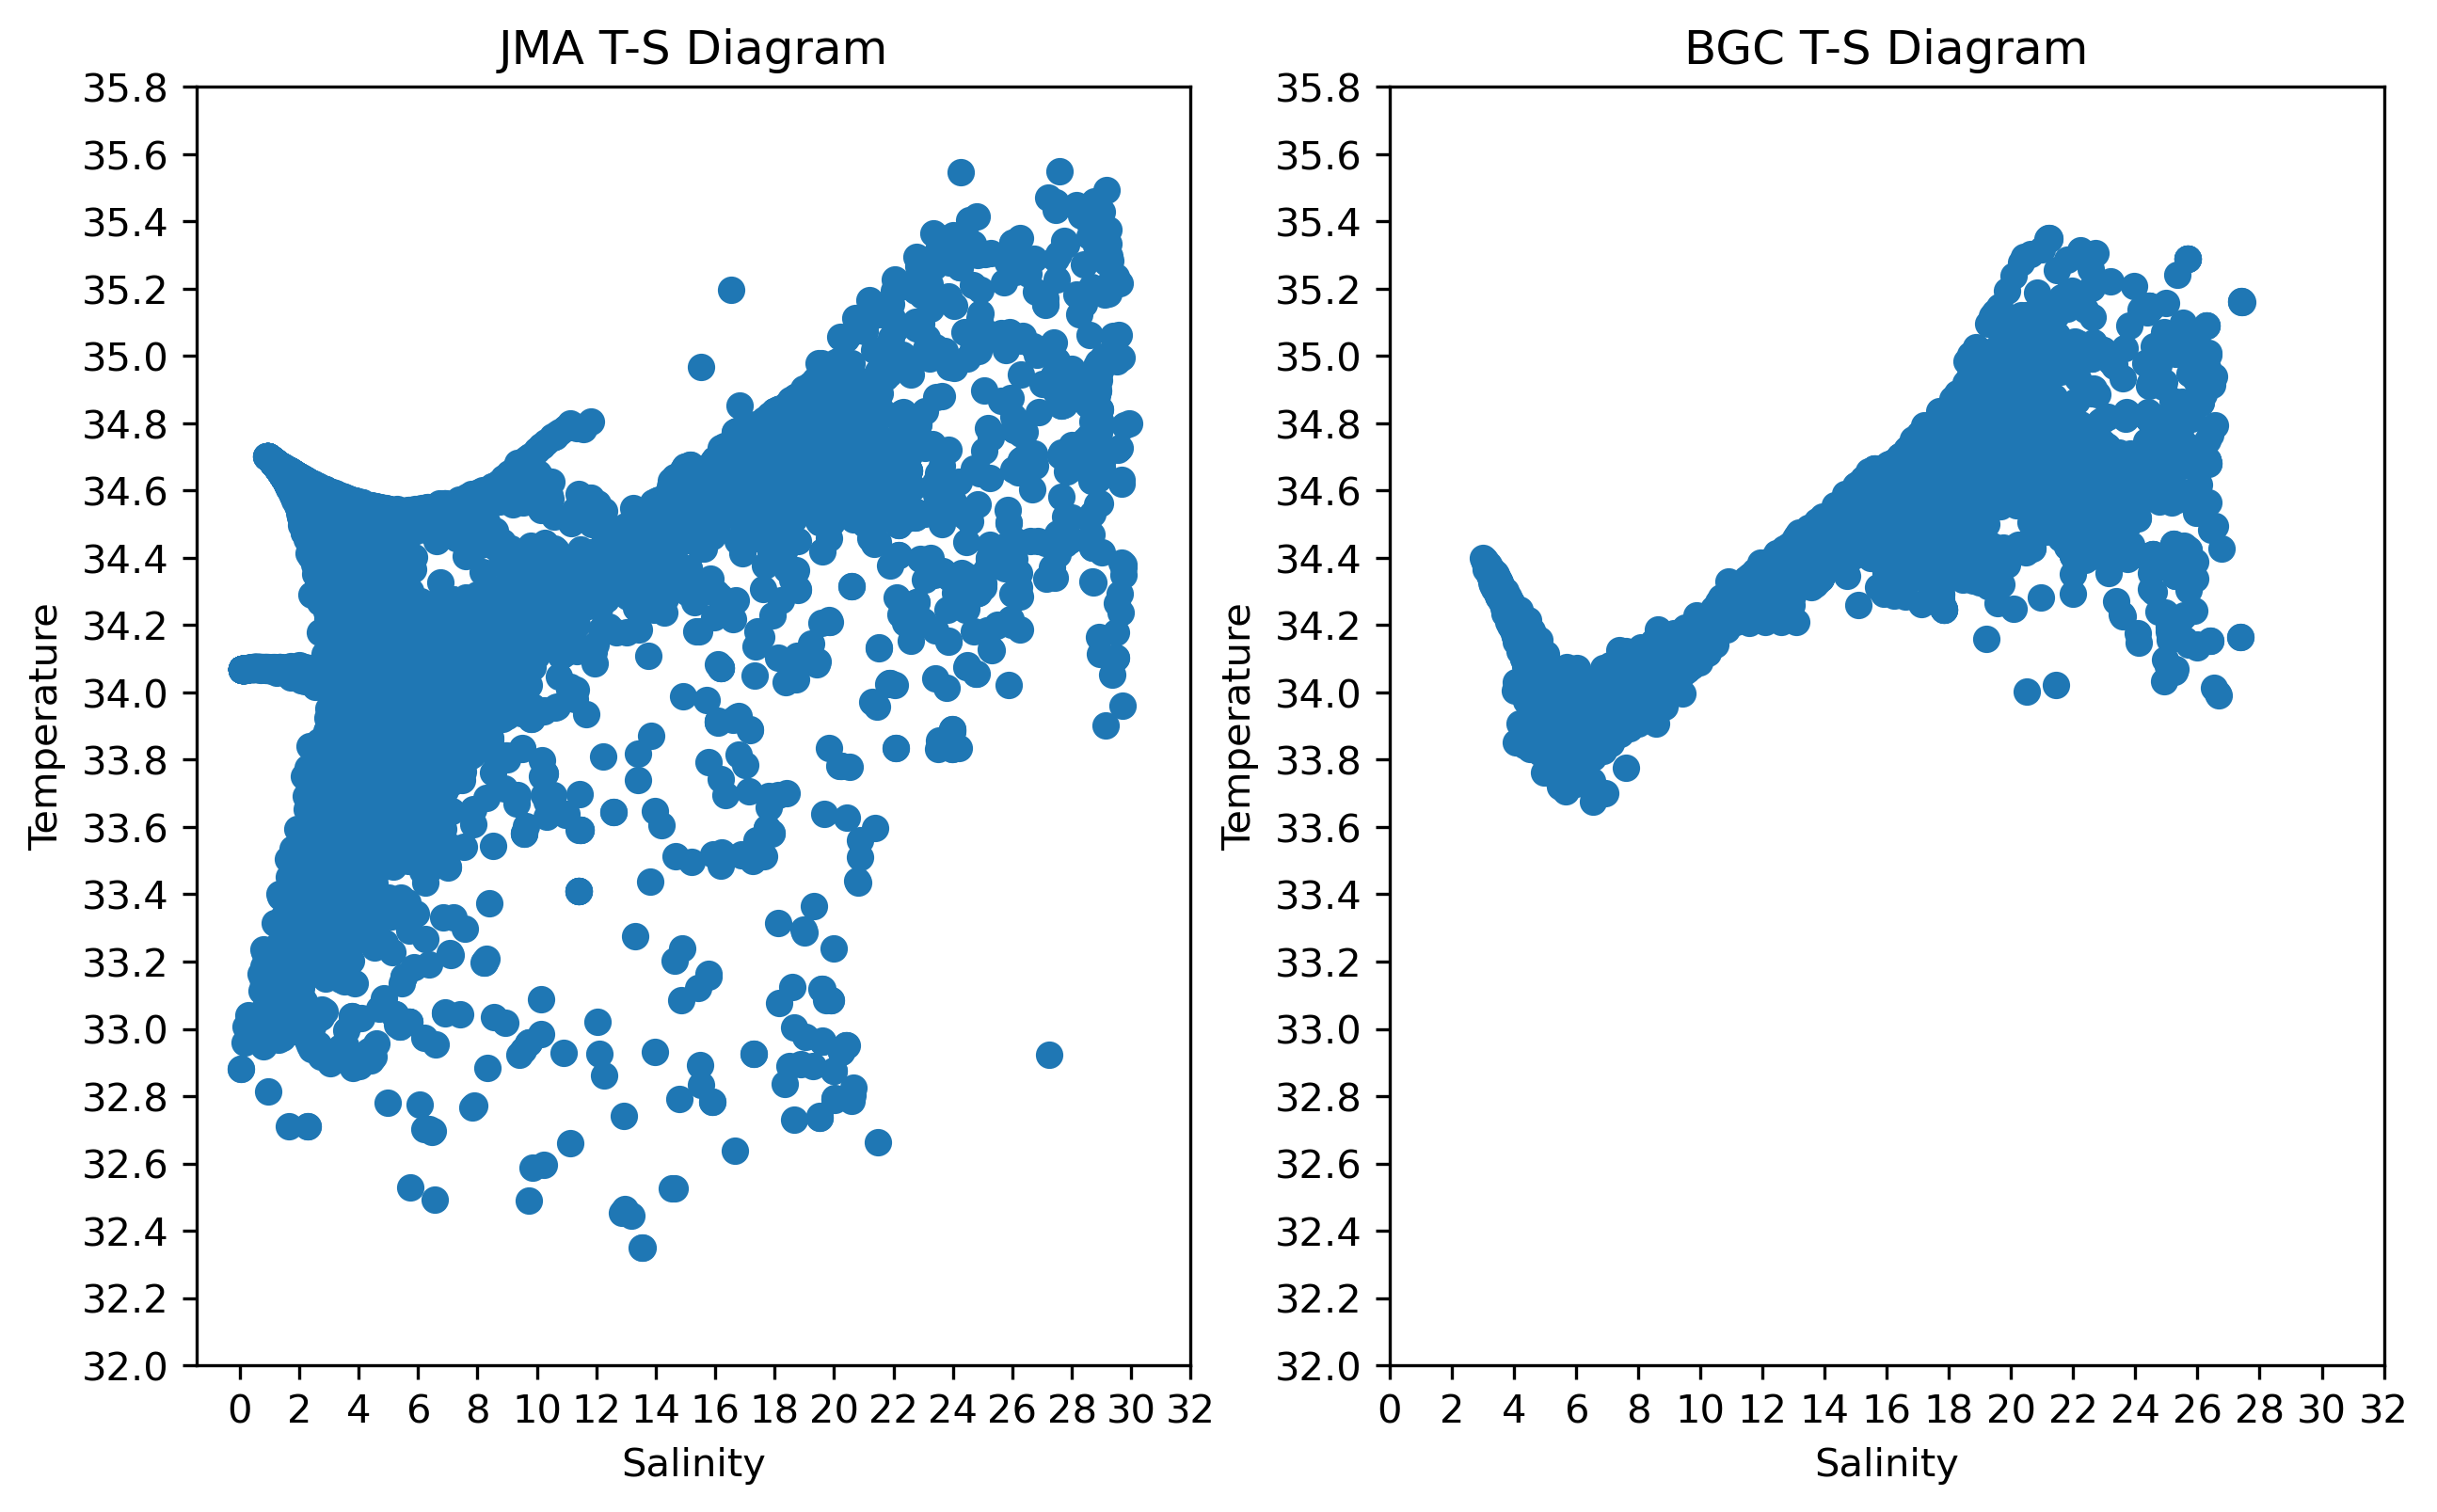

In [62]:
fig, [ax1,ax2] = plt.subplots(1,2, figsize= (10,6), dpi = 300)
# c1=ax1.scatter(jmadata['theta'],jmadata['sal'],30, jmadata['nitrate'])
# c2=ax2.scatter(bgcno3data['TEMPERATURE[C]'],bgcno3data['SALINITY[PSS]'],30, bgcno3data['NITRATE[uMOL/KG]'])

c1=ax1.scatter(jmadata['theta'],jmadata['sal'])
c2=ax2.scatter(bgcno3data['TEMPERATURE[C]'],bgcno3data['SALINITY[PSS]'])


ax1.set_xlabel('Salinity')
ax1.set_ylabel('Temperature')

ax2.set_xlabel('Salinity')
ax2.set_ylabel('Temperature')

ax1.set_xticks(np.arange(0, 33, 2))
ax2.set_xticks(np.arange(0, 33, 2))

ax1.set_yticks(np.arange(32, 36, 0.2))
ax2.set_yticks(np.arange(32, 36, 0.2))

ax1.set_title("JMA T-S Diagram")
ax2.set_title("BGC T-S Diagram")


In [63]:
# Make the depth range match that of the JMA data (positive numbers)
bgcno3data['DEPTH[M]'] = bgcno3data['DEPTH[M]']*-1

## Part 2 (40 points): Model application and evaluation

Apply your nitrate model trained on the JMA dataset to the BGC Argo data to estimate nitrate concentrations based on your input variables (e.g. temperature, salinity, etc…).

Compare the observed BGC Argo nitrate to the values predicted by your model.

Report the r2 score and RMSE (root mean squared error).
Does your model perform consistently well, or are there any noticeable outliers? If there are, identify those data points and suggest reasons why you think that your model performs less well for those points.

In [12]:
# Make the data split
y = jmadata.nitrate
X = jmadata[['density','depth','sal']]

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=4)
# test size is the percentage of test points you want, random state is the "seed" number so people can reproduce what you have done

We decided to use density, depth, and salinity for our x variables. Including all three produced a better model than just using one, and other shared variables (location and time) produced a far too complicated and overfit model. 

We split the JMA data into 20% test and 80% training data.

In [ ]:
# just to look and check on the split of jma data
len(X_test)

3115

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
standardized_X = scaler.transform(X_train)
standardized_X_test = scaler.transform(X_test)

We scaled our data using Standard scaler, since all the data is on different scales (different ranges of numbers.)

In [ ]:
# pick model
n  = int(input('Choose a number for k: '))

from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=n)
model.fit(standardized_X, y_train)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model.score(standardized_X, y_train)))

# plot the model together with the data
y_pred = model.predict(standardized_X_test)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

from sklearn.metrics import mean_squared_error, r2_score


print('r2 =', r2_score(y_train, model.predict(standardized_X)))
print('r2 =', r2_score(y_test, y_pred))
print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred)))
# we want to minimize RMSE with our model (its how good our model is)

Choose a number for k: 5
R^2 score: 0.99
r2 = 0.9943372977551326
r2 = 0.990611151547529
RMSE = 1.495061158097771


We used the input k code to try a couple different models and get a feel for what values of k were realistic. 1000 was an unrealistic (very poor) model, but below 100 - specifically below 30 showed to have some of the best results. 

In [77]:
# For loop to find the best model k
k = []
r2_train = []
r2_test = []
RMSE = []

loops = range(1,31)

for n in loops:
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(standardized_X, y_train)

    # Use the model to predict y (nitrate values)
    y_pred = model.predict(standardized_X_test)
    
    # Form our lists to plot
    k.append(n)
    r2_train.append(r2_score(y_train, model.predict(standardized_X)))
    r2_test.append(r2_score(y_test, y_pred))
    RMSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))

Text(0, 0.5, 'r2 for test')

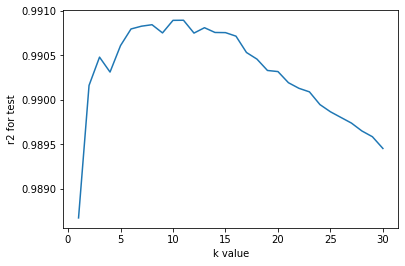

In [78]:
plt.plot(k,r2_test)
plt.xlabel('k value')
plt.ylabel('r2 for test')

Text(0, 0.5, 'RMSE')

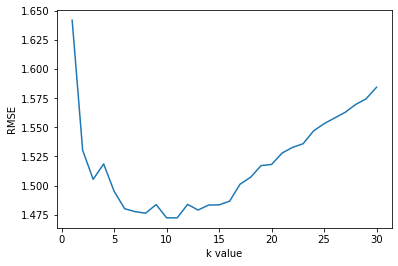

In [79]:
plt.plot(k,RMSE)
plt.xlabel('k value')
plt.ylabel('RMSE')

When running with 100 versions of k (1-100) shows that RMSE increases and r^2 decreases after around 30. Thus, we ran the loop again with only 1-30 for k. We chose k = 10, since it has the lowest RMSE and highest r^2. Plotting of predicted data with the actual test data showed potential overfitting, so we decided on k = 15, which had a better model r^2 than k=10 or k=5. Using less neighbors did not produce as good of a prediction as using more nearest neighbors to predict the nitrate value.

In [80]:
# Run the model at k = 15
from sklearn.neighbors import KNeighborsRegressor
model15 = KNeighborsRegressor(n_neighbors= 15)
model15.fit(standardized_X, y_train)

# compute the R^2 score
print("R^2 score: {0:.2f}".format(model15.score(standardized_X, y_train)))

# plot the model together with the data
y_pred_15 = model15.predict(standardized_X_test)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

from sklearn.metrics import mean_squared_error, r2_score


print('r2 =', r2_score(y_train, model15.predict(standardized_X)))
print('r2 =', r2_score(y_test, y_pred_15))
print('RMSE =',np.sqrt(mean_squared_error(y_test, y_pred_15)))
# we want to minimize RMSE with our model (its how good our model is)

R^2 score: 0.99
r2 = 0.992036186703088
r2 = 0.9907569168125224
RMSE = 1.4834100770211223


Although it's not the highest of the potential r^2 values, 0.9907 (or the r^2 for the prediction based on the test) is still a very good model for predicting NO3 from density, depth, and salinity. A RMSE of 1.48 is on the very low side, also suggesting that the model is good at prediciting NO3 values close to actual NO3 values. 

In [17]:
# Need to pull out each X variable for plotting
density_test = X_test[['density']]
depth_test = X_test[['depth']]
sal_test = X_test[['sal']]

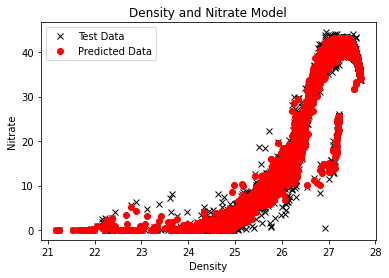

In [18]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(density_test, y_test, 'xk', label = "Test Data")
plt.plot(density_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model')
plt.legend()

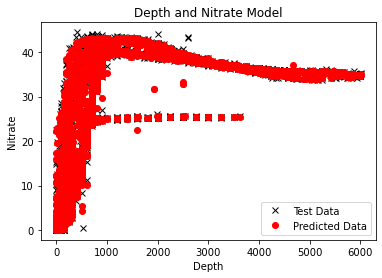

In [23]:
plt.plot(depth_test, y_test, 'xk', label = "Test Data")
plt.plot(depth_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model')
plt.legend()

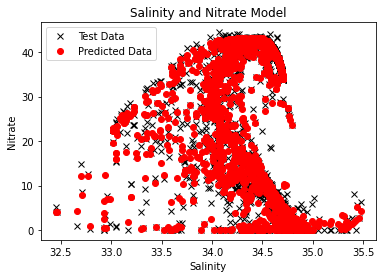

In [24]:
plt.plot(sal_test, y_test, 'xk', label = "Test Data")
plt.plot(sal_test, y_pred_15, 'ro', label = "Predicted Data")
plt.xlabel('Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model')
plt.legend()

In [81]:
# Test the model with the BGC Argo data
# bgcdata and bgcno3data
X_bgc = bgcno3data[['SIGMATHETA[KG/M3]','DEPTH[M]','SALINITY[PSS]']]

# scaler = StandardScaler().fit(X_train)
stand_X_bgc = scaler.transform(X_bgc)

# plot the model together with the data
bgc_y_pred = model15.predict(stand_X_bgc)

#plt.scatter(standardized_X, y_train)
#plt.plot(standardized_X_test,y_pred)
#plt.show()

y_bgc = bgcno3data[['NITRATE[uMOL/KG]']]


print('r2 =', r2_score(y_bgc, bgc_y_pred))
print('RMSE =',np.sqrt(mean_squared_error(y_bgc, bgc_y_pred)))
# we want to minimize RMSE with our model (its how good our model is)

r2 = 0.9523667663390072
RMSE = 2.8730859764868515


In [73]:
# Need to pull out each standardized X variable for plotting
bgc_density = bgcno3data['SIGMATHETA[KG/M3]']
bgc_depth = bgcno3data['DEPTH[M]']
bgc_sal = bgcno3data['SALINITY[PSS]']

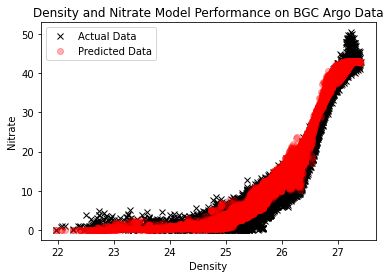

In [74]:
# Plot to check for overfitting (will follow the outliers exactly)
plt.plot(bgc_density, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_density, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Density')
plt.ylabel('Nitrate')
plt.title('Density and Nitrate Model Performance on BGC Argo Data')
plt.legend()

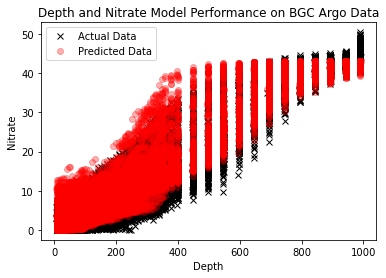

In [75]:
plt.plot(bgc_depth, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_depth, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Depth')
plt.ylabel('Nitrate')
plt.title('Depth and Nitrate Model Performance on BGC Argo Data')
plt.legend()

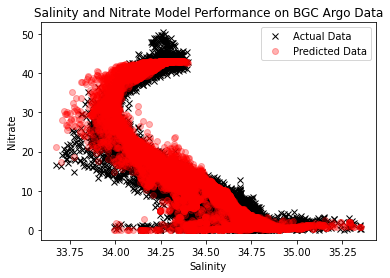

In [76]:
plt.plot(bgc_sal, y_bgc, 'xk', label = "Actual Data")
plt.plot(bgc_sal, bgc_y_pred, 'ro', alpha = 0.3, label = "Predicted Data")
plt.xlabel('Salinity')
plt.ylabel('Nitrate')
plt.title('Salinity and Nitrate Model Performance on BGC Argo Data')
plt.legend()